In [247]:
import io,os , requests, json, datetime, uuid,base64,json,csv,pickle,uuid,requests,time
from PIL import Image,PngImagePlugin
from xml.dom.pulldom import parseString
from flask import Flask, flash, redirect, render_template, send_file,request, session, abort, escape,jsonify
from PIL import Image,PngImagePlugin, ImageOps
from threading import Thread 

In [2]:
url = "http://127.0.0.1:7861"

In [3]:
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}
queue = {}

In [4]:
imageDic = {}
with open('images.tsv', mode ='r',encoding='utf8')as file:
    line = file.readline()
    assert line.strip().startswith('UUID\tparameters'), "Data format error!"
    line = file.readline()
    while line:
        cache = line.strip().split('\t')
        imageDic[cache[0]] = json.loads(' '.join(cache[1:]))
        line = file.readline()

# clean
del line
del cache

In [5]:
imageDic

{'0216077-d5d4-4e63-beb4-3a392c93f887': {'prompt': 'high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset',
  'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans',
  'steps': 32,
  'sampler_index': 'DPM2 Karras',
  'cfg_scale': 11.0,
  'seed': 595727703,
  'width': 1024,
  'height': 512,
  'model_hash': 'e6e8e1fc',
  'denoising_strength': 0.0},
 '246ac8ac-9155-4a84-a17f-797f91dde1ad': {'prompt': 'high quality,highres,\\n1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset\\n\\\\nmasterpiece',
  'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fi

In [29]:
# from diffusers import StableDiffusionPipeline
# import torch
# from torch import autocast

In [30]:
# pipe = StableDiffusionPipeline.from_pretrained(
#     'hakurei/waifu-diffusion',
#     torch_dtype=torch.float32
# ).to('cuda')

In [31]:
# with autocast("cuda"):
#     image = pipe(prompt, guidance_scale=11).images[0]  

In [32]:
# image.save("test.png")

In [6]:
def formDicFromString(inputString):
    denoising_strength = inputString.partition("Denoising strength:")[2].partition(',')[0]
    denoising_strength = denoising_strength if denoising_strength else '0.0'
    model_hash = inputString.partition("Model hash:")[2].partition(',')[0]
    size = inputString.partition("Size:")[2].partition(',')[0]
    width,null,height = size.strip(', \n').partition('x')
    seed = inputString.partition("Seed:")[2].partition(',')[0]
    cfg = inputString.partition("CFG scale:")[2].partition(',')[0]
    sampler = inputString.partition("Sampler:")[2].partition(',')[0]
    steps = inputString.partition("Steps:")[2].partition(',')[0]
    pos_prompt,null,neg_prompt = inputString.rpartition("Negative prompt:")
    neg_prompt = neg_prompt.rpartition("\n")[0]
    return {
        'prompt'            : pos_prompt.strip(', \n'),
        'negative_prompt'   : neg_prompt.strip(', \n'),
        'steps'             : int(steps.strip(', \n')),
        "sampler_index"     : sampler.strip(', \n'),
        "cfg_scale"         : float(cfg.strip(', \n')),
        "seed"              : int(seed.strip(', \n')),
        "width"             : int(width.strip(', \n')),
        "height"            : int(height.strip(', \n')),
        "model_hash"        : model_hash.strip(', \n'),
        "denoising_strength": float(denoising_strength.strip(', \n'))
    }


In [7]:
def storeImg(img,params):
    # img need to be a pil object
    myUUID = str(uuid.uuid4())
    if not os.path.isdir("static/"+myUUID[:3]):
        os.makedirs("static/"+myUUID[:3])
    pnginfo_data = PngImagePlugin.PngInfo()
    for k, v in params.items():
        pnginfo_data.add_text(k, str(v))
    img.save("static/"+myUUID[:3]+'/'+myUUID+'.png', pnginfo=pnginfo_data)
    params['denoising_strength'] = params['denoising_strength'] if params['denoising_strength'] else 0.0
    dic = {
        'prompt'            : params['prompt'].strip(', \n'),
        'negative_prompt'   : params['negative_prompt'].strip(', \n'),
        'steps'             : int(params['steps']),
        "sampler_index"     : params['sampler'].strip(', \n'),
        "cfg_scale"         : float(params['cfg_scale']),
        "seed"              : int(params['seed']),
        "width"             : int(params['width']),
        "height"            : int(params['height']),
        "model_hash"        : params['sd_model_hash'].strip(', \n'),
        "denoising_strength": float(params['denoising_strength'])
    }
    with open('images.tsv', mode ='a',encoding='utf8')as file:
        file.write(myUUID+'\t'+json.dumps(dic)+'\n')
    imageDic[myUUID] = dic

In [8]:
def findFileFromUUID(UUID):
    fileNames = ['static/'+UUID[:3]+'/'+UUID+'.'+file_extension for file_extension in ALLOWED_EXTENSIONS]
    for fileName in fileNames:
        if os.path.isfile(fileName):
            return fileName
    return ''

In [9]:
def getImageParamsFromFile(UUID):
    path = findFileFromUUID(UUID)
    if path == '':
        print('File with UUID of '+ UUID+ " is not found!")
        return {}
    with open(path, "rb") as image_file:
        bs64_str = base64.b64encode(image_file.read())
    payload = 'data:image/png;base64,'+bs64_str.decode()
    res = requests.post(url+'/sdapi/v1/png-info', json = {'image':payload}).json()['info']
    return formDicFromString(res)

In [10]:
sample_text_promt = {
  "prompt": "cloud, high quality,highres,1girl,cloud, scenery, sunset",
  "seed": -1,
  "steps": 32,
  "cfg_scale": 11,
  "width": 1024,
  "height": 512,
  "negative_prompt": "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans",
  "sampler_index": "DPM2 Karras"
}


In [38]:
sample_text_promt

{'prompt': 'cloud, high quality,highres,1girl,cloud, scenery, sunset',
 'seed': -1,
 'steps': 32,
 'cfg_scale': 11,
 'width': 1024,
 'height': 512,
 'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans',
 'sampler_index': 'DPM2 Karras'}

In [11]:
imageDic['0216077-d5d4-4e63-beb4-3a392c93f887']

{'prompt': 'high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset',
 'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans',
 'steps': 32,
 'sampler_index': 'DPM2 Karras',
 'cfg_scale': 11.0,
 'seed': 595727703,
 'width': 1024,
 'height': 512,
 'model_hash': 'e6e8e1fc',
 'denoising_strength': 0.0}

In [12]:
def generateImage(params):
    myUUID = str(uuid.uuid4())
    queue[myUUID] = params
    return myUUID

In [13]:
def newLike(UUID):
    print("Generating a Image like "+UUID+"...")
    if not UUID in imageDic:
        return send_file('static/no_source_image.webp')
    if imageDic[UUID]['sampler_index'] == '':
        return send_file('static/please_select_a_Stable_diffused_image.webp')
    justLikeDic = imageDic[UUID].copy()
    justLikeDic['seed'] = -1
    # res = requests.post(url+'/sdapi/v1/txt2img', json = justLikeDic)
    return json.dumps({'UUID':generateImage(justLikeDic),'Queue':len(queue)})
    

In [56]:
newLike('0216077-d5d4-4e63-beb4-3a392c93f887')

Generating a Image like 0216077-d5d4-4e63-beb4-3a392c93f887...


'{"UUID": "efb50313-ec75-4ff6-a21d-f8c50de9dd6e", "Queue": 1}'

In [15]:
queue

{}

In [14]:
next(iter(queue))

StopIteration: 

In [ ]:
blackImageUUID = '48e8d060-c5b6-4748-9304-185aa4fdfdf2'

In [45]:
def imageIsBlack(img):
    #TODO: need to implement check if image is black
    return False

In [47]:
def processor():
    while True:
        print(len(queue))
        global stop_thread
        if stop_thread:
            break
        if len(queue) > 0:
            UUID = next(iter(queue))
            res = requests.post(url+'/sdapi/v1/txt2img', json = queue[UUID])
            img = res.json()["images"][0]
            info = json.loads(res.json()["info"])
            info['parameters'] = info['infotexts'][0].strip('\'')
            del info['infotexts']
            if img.startswith("data:image/png;base64,"):
                img = img[len("data:image/png;base64,"):]
            img = base64.decodebytes(img.encode())
            img = Image.open(io.BytesIO(img))
            if imageIsBlack(img):
                continue
            else:
                del queue[UUID]
            storeImg(img,info)
        time.sleep(1)


In [50]:
stop_thread = False
thread = Thread(target = processor)
thread.start()

1


0
0
0
0
0


In [53]:
stop_thread = True
thread.join()

In [16]:
justLikeDic = imageDic['0216077-d5d4-4e63-beb4-3a392c93f887'].copy()

In [53]:
justLikeDic['seed'] = -1

In [97]:
justLikeDic

{'prompt': 'high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset',
 'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans',
 'steps': 32,
 'cfg_scale': 11.0,
 'seed': -1,
 'width': 1024,
 'height': 512,
 'model_hash': 'e6e8e1fc',
 'denoising_strength': 0.0,
 'sampler_index': 'DPM2 Karras'}

In [102]:
res = requests.post(url+'/sdapi/v1/txt2img', json = justLikeDic)

In [57]:
img = res.json()["images"][0]
info = json.loads(res.json()["info"])
info['parameters'] = info['infotexts'][0].strip('\'')
del info['infotexts']
info['parameters']

KeyError: 'images'

In [42]:
res.json()["parameters"]

{'enable_hr': False,
 'denoising_strength': 0.0,
 'firstphase_width': 0,
 'firstphase_height': 0,
 'prompt': 'high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset',
 'styles': None,
 'seed': -1,
 'subseed': -1,
 'subseed_strength': 0,
 'seed_resize_from_h': -1,
 'seed_resize_from_w': -1,
 'batch_size': 1,
 'n_iter': 1,
 'steps': 32,
 'cfg_scale': 11.0,
 'width': 1024,
 'height': 512,
 'restore_faces': False,
 'tiling': False,
 'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans',
 'eta': None,
 's_churn': 0.0,
 's_tmax': None,
 's_tmin': 0.0,
 's_noise': 1.0,
 'override_settings

In [103]:
res.json()["info"]

'{"prompt": "high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset", "all_prompts": ["high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset"], "negative_prompt": "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans", "seed": 3897137661, "all_seeds": [3897137661], "subseed": 1590214003, "all_subseeds": [1590214003], "subseed_strength": 0, "width": 1024, "height": 512, "sampler_index": 11, "sampler": "DDIM", "cfg_scale": 11.0, "steps": 32, "batch_size": 1, "restore_faces": false, "face_restoration_model": null, "sd_model_hash": "e6e8e1fc", "seed_resize_from_w": -1, "seed

In [21]:
with open("static/117/117d8712-8ae0-4968-9328-d9905692e967.png", "rb") as image_file:
    bs64_str = base64.b64encode(image_file.read())
decoded_string =io.BytesIO(base64.b64decode(bs64_str))
sampleImage = Image.open(decoded_string)

In [22]:
with open("static/48e/48e8d060-c5b6-4748-9304-185aa4fdfdf2.png", "rb") as image_file:
    bs64_str = base64.b64encode(image_file.read())
decoded_string =io.BytesIO(base64.b64decode(bs64_str))
blkImage = Image.open(decoded_string)

In [24]:
blkImage.show()

In [29]:
not sampleImage.getbbox()

False

In [20]:
if img.startswith("data:image/png;base64,"):
    img = img[len("data:image/png;base64,"):]

In [24]:
imgtest = base64.decodebytes(img.encode())

In [46]:
if img.startswith("data:image/png;base64,"):
    img = img[len("data:image/png;base64,"):]
img = base64.decodebytes(img.encode())
img = Image.open(io.BytesIO(img))

In [47]:
img.show()

In [48]:
info

{'prompt': 'high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset',
 'all_prompts': ['high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset'],
 'negative_prompt': 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans',
 'seed': 1584931009,
 'all_seeds': [1584931009],
 'subseed': 3364850668,
 'all_subseeds': [3364850668],
 'subseed_strength': 0,
 'width': 1024,
 'height': 512,
 'sampler_index': 9,
 'sampler': 'DDIM',
 'cfg_scale': 11.0,
 'steps': 32,
 'batch_size': 1,
 'restore_faces': False,
 'face_restoration_model': None,
 'sd_model_hash': 'e6e8e1fc',
 'seed_resize_fr

In [49]:
storeImg(img,info)

In [45]:
payload = res.json()["images"][0]

In [25]:
json.dumps(getImageParamsFromFile('0216077-d5d4-4e63-beb4-3a392c93f887'))

'{"prompt": "high quality,highres,1girl, cloud, high quality,highres,1girl,cloud, scenery, sunset", "negative_prompt": "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry,no_humans", "steps": 32, "sampler_index": "DPM2 Karras", "cfg_scale": 11.0, "seed": 595727703, "width": 1024, "height": 512, "model_hash": "e6e8e1fc", "denoising_strength": 0.0}'

In [31]:
test = 'lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry'

In [35]:
set(test.replace(', ',',').split(','))

{'bad anatomy',
 'bad hands',
 'blurry',
 'cropped',
 'error',
 'extra digit',
 'fewer digits',
 'jpeg artifacts',
 'low quality',
 'lowres',
 'missing fingers',
 'normal quality',
 'signature',
 'text',
 'username',
 'watermark',
 'worst quality'}

In [36]:
','.join(set(test.replace(', ',',').split(',')))

'text,worst quality,low quality,bad anatomy,error,jpeg artifacts,cropped,bad hands,watermark,blurry,missing fingers,fewer digits,extra digit,username,normal quality,signature,lowres'

In [34]:
','.join()

'lowres,bad anatomy,bad hands,text,error,missing fingers,extra digit,fewer digits,cropped,worst quality,low quality,normal quality,jpeg artifacts,signature,watermark,username,blurry'

In [262]:
pilImage = Image.open('sample.jpg',mode='r') 

In [263]:
pilImage= ImageOps.exif_transpose(pilImage)

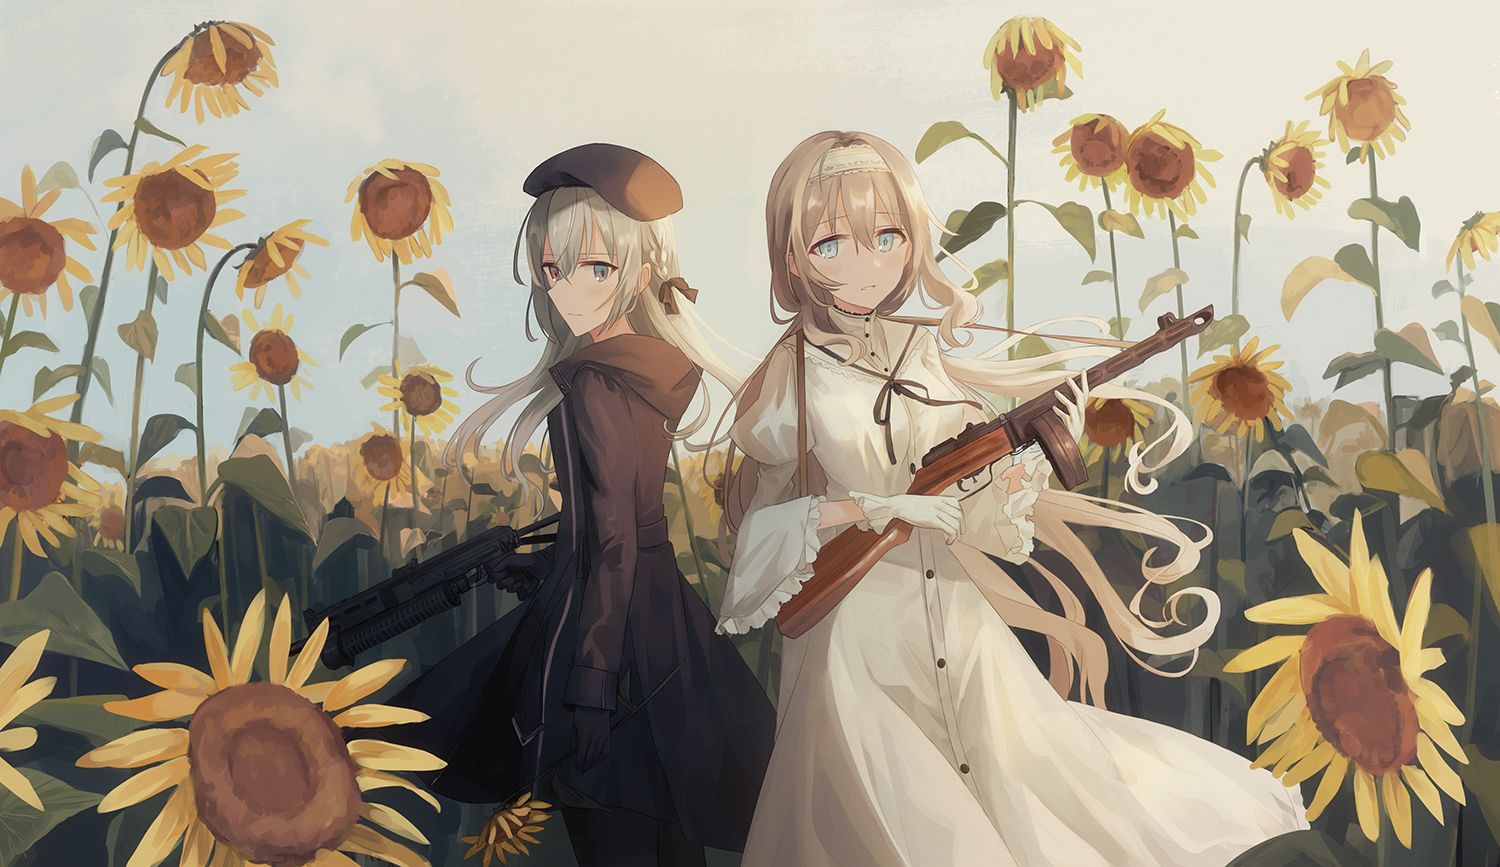

In [264]:
display(pilImage)

In [256]:
width , height = pilImage.size
print(width)
print(height)

2992
2992


In [64]:
if width < 512 or height < 512:
    pass

In [219]:
width , height = (2048,514)

In [198]:
124//2

62

In [266]:
width , height = pilImage.size
# find the best new width and height to minimize error
ratio = width / height
new_height = 512
new_width = new_height
while True:
    error = abs((new_width / new_height) - ratio)
    if error > abs(((new_width +64) / new_height) - ratio):
        new_width = new_width + 64
    elif error > abs((new_width  / (new_height+64)) - ratio):
        new_height = new_height + 64
    else:
        # error is minimized
        break
width_scale = width / new_width
height_scale = height / new_height
if width_scale > height_scale:
    # we scale with the height scale and crop the width
    cropped_width = int(height_scale * new_width)
    left_crop = (width - cropped_width) //2
    right_crop = width - cropped_width - left_crop
    pilImage = pilImage.crop((left_crop,0,width-right_crop,height))
else:
    # we scale with the width scale and crop the height
    cropped_height = int(width_scale * new_height)
    top_crop = (height - cropped_height) //2
    bottom_crop = height - cropped_height - top_crop
    pilImage = pilImage.crop((0,top_crop,width,height-bottom_crop))
# resizing the image for stable diffusion
pilImage = pilImage.resize((new_width,new_height), resample=Image.Resampling.HAMMING)

In [258]:
pilImage.size

(512, 512)

In [240]:
pilImage.size[0]/pilImage.size[1]

1.750291715285881

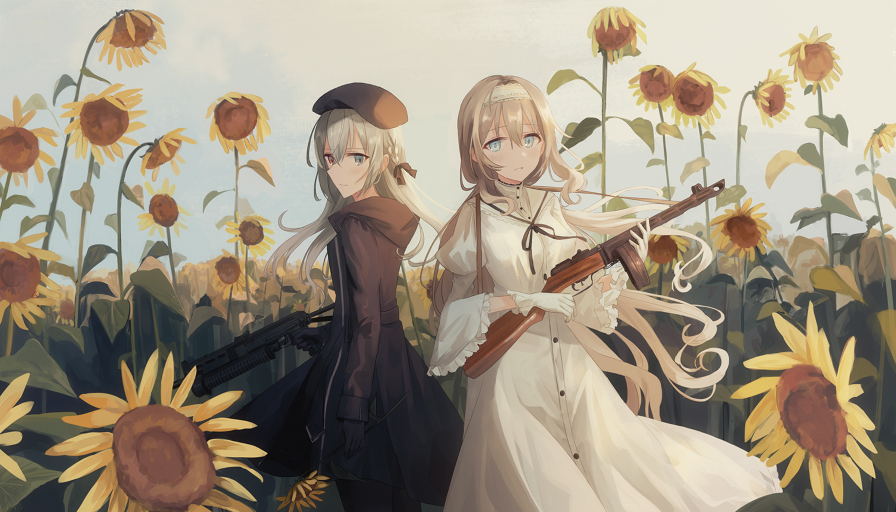

In [267]:
display(pilImage)

In [241]:
pilImage = pilImage.resize((new_width,new_height), resample=Image.Resampling.HAMMING)

In [242]:
pilImage.size[0]/pilImage.size[1]

1.75

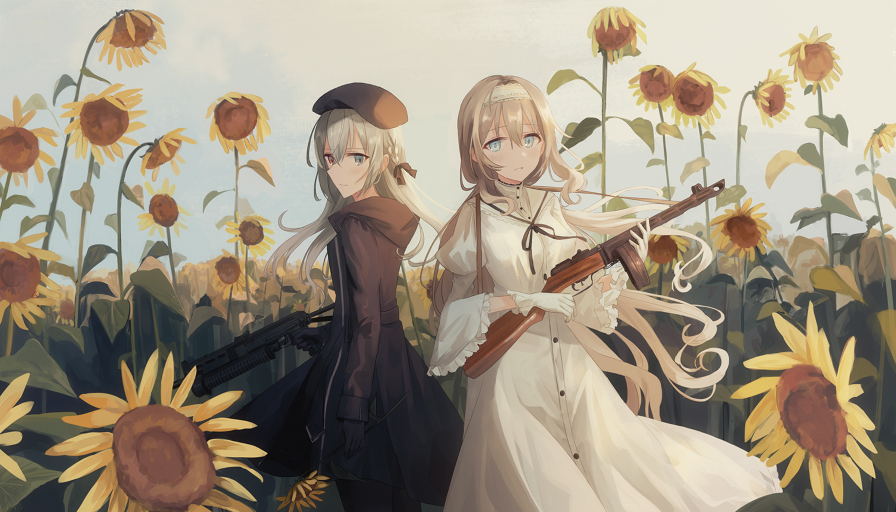

In [243]:
display(pilImage)

In [216]:
width_scale

1.032258064516129

In [221]:
left_crop,right_crop

(13, 13)

In [222]:
top_crop,bottom_crop

(1, 1)

In [215]:
height_scale

1.01953125

In [194]:
1.4545454545454546 * 512

744.7272727272727

In [217]:
new_width

1984

In [218]:
new_height

512

In [106]:
abs((new_width / new_height) - ratio)

0.10510380622837379

In [101]:
new_width * ratio

1439.446366782007

In [99]:
new_width - new_width % 64

832

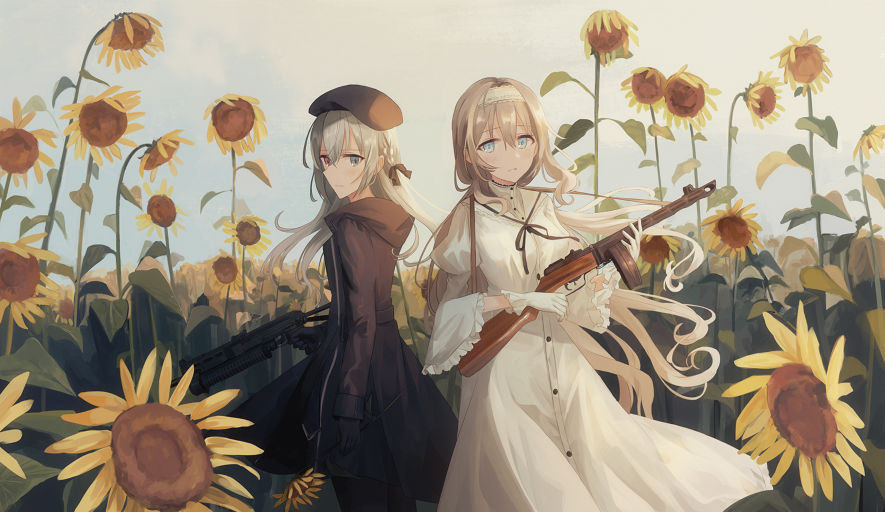

In [82]:
display(pilImage.resize((width,height), resample=Image.Resampling.HAMMING))

In [66]:
width

885.8131487889274

In [ ]:
display(pilImage.resize((width,512), resample=Image.Resampling.HAMMING))

In [43]:
1024 * 512 // 2048

256

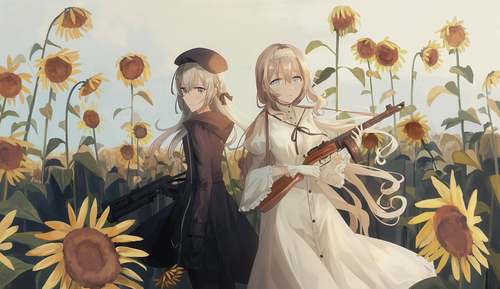

In [56]:
display(pilImage.resize((500,289), resample=Image.Resampling.LANCZOS))

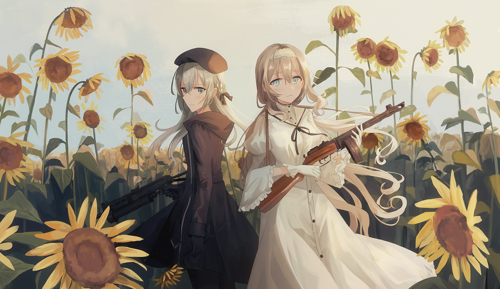

In [57]:
display(pilImage.resize((500,289), resample=Image.Resampling.BICUBIC))

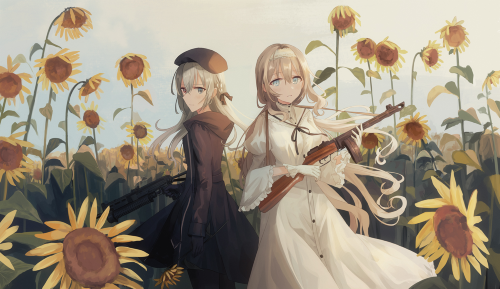

In [58]:
display(pilImage.resize((500,289), resample=Image.Resampling.HAMMING))

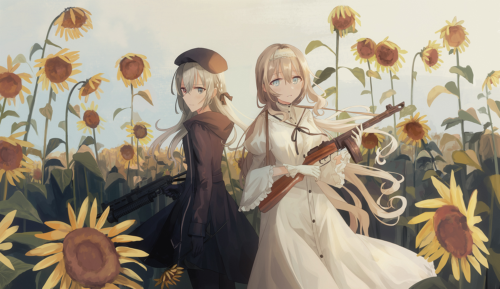

In [59]:
display(pilImage.resize((500,289), resample=Image.Resampling.BILINEAR))

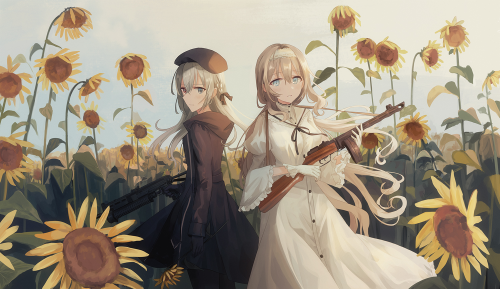

In [60]:
display(pilImage.resize((500,289), resample=Image.Resampling.BOX))